# Zero Crossing - in frequency domain.

Zero Crossing is a great technique to process sound fast and to store it in a compact way,
but there are some limitations. This is an attempt to do something similar with FFT (...yes I know, I'm not the first one...).

Basic ideas:

- Keep it fast by using time domain techniques to determine where to run FFT.
- Add support for multiple harmonics. (TODO: Later, it's too hard...)
- Add support for amplitude measured as dBFS.
- Try to dynamically adjust to noise level.
- Extract metrics suitable to visualise in a scatter plot.
- Think of bat sound as "sparse data", not "densed data" as it is in music files.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Math and sound processing.
import numpy as np
import pandas as pd
import scipy.signal
import wave
import librosa
import librosa.display

### Load the file

Load the file and take a look at it.

In [3]:
# Basic settings.
#sound_file = '../data_in/Mdau_TE384.wav'
sound_file = '../data_in/Ppip_TE384.wav'
cutoff_freq_hz = 15000

In [4]:
# Load sound file.
###signal, sr = librosa.load(sound_file, sr=None)
wave_file = wave.open(sound_file, 'rb')
samp_width = wave_file.getsampwidth()
frame_rate = wave_file.getframerate()

In [5]:
# Check if TE, Time Expansion.
sampling_freq = frame_rate
if sampling_freq < 192000:
    sampling_freq *= 10
# Read one sec per buffer.
buffer_size = sampling_freq
signal_buffer = wave_file.readframes(buffer_size)
# Transform from int to float in the range [-1, 1].
signal = librosa.util.buf_to_float(signal_buffer, n_bytes=samp_width)


In [6]:
# Sound file info.
print('Sampling freq in file (after TE): ' + str(frame_rate) + ' Hz.')
print('Original sampling freq: ' + str(sampling_freq) + ' Hz.')
print(str(len(signal)) + ' samples.')
print('Original rec. length: ' + str(len(signal) / sampling_freq) + ' sec.')

Sampling freq in file (after TE): 38400 Hz.
Original sampling freq: 384000 Hz.
384000 samples.
Original rec. length: 1.0 sec.


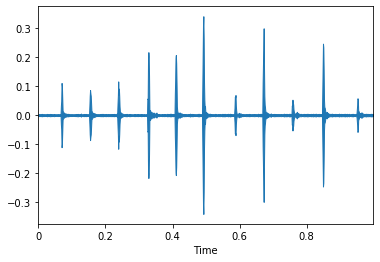

In [7]:
# Plot. Time is real time.
librosa.display.waveplot(signal, sr=sampling_freq)
plt.show()

/home/parallels/Desktop/dev/w_cloudedbats/cloudedbats_dsp/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


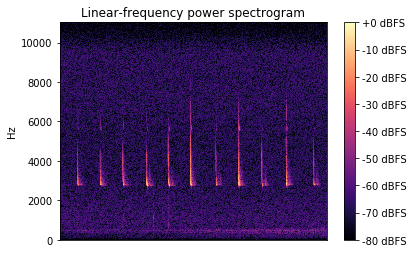

In [8]:
# Plot spectrogram. Note: Wrong Hz due to librosas default sr at 22050.
D = librosa.amplitude_to_db(librosa.stft(signal), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dBFS')
plt.title('Linear-frequency power spectrogram')
plt.show()

### Find amplitude peaks.

- Check noise level.
- Look for amplitude peaks in time domain to make i fast.

In [9]:
# Noise level. RMS, root-mean-square. Calculated for the whole file.
noise_level = np.sqrt(np.mean(np.square(signal)))
noise_level_dbfs = 20 * np.log10(np.abs(noise_level) / 1.0)
print('Noise: ' + str(noise_level) + ' noise-dbfs: ' + str(noise_level_dbfs))

Noise: 0.016458211 noise-dbfs: -35.67234723710384


In [10]:
# Find peaks in time domain (rmse and localmax).
def find_peaks(y, hop_length):
    y2 = y.copy()
    #rms_tot = np.sqrt(np.mean(np.square(y)))
    #y2[(np.abs(y2) < (rms_tot * 2.0))] = 0.0
    y2[(np.abs(y2) < (noise_level * 2.0))] = 0.0
    rmse = librosa.feature.rms(y=y2, hop_length=hop_length, frame_length=1024, center=True)
    locmax = librosa.util.localmax(rmse.T)
    maxindexlist = []
    for index, a in enumerate(locmax):
        if a: maxindexlist.append(index)
    index_list = librosa.frames_to_samples(maxindexlist, hop_length=hop_length)
    return index_list

In [11]:
%%timeit
peaks = find_peaks(signal, hop_length=384)

4.01 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
peaks = find_peaks(signal, hop_length=384)

In [13]:
print(len(peaks))
peaks

11


array([ 26880,  59520,  91776, 126336, 157440, 188928, 225792, 258048,
       291456, 326400, 365568])

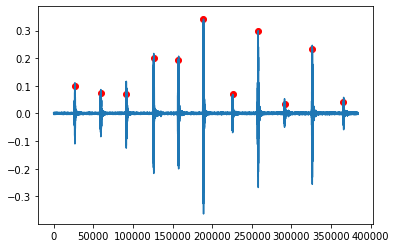

In [14]:
plt.plot(signal)
plt.scatter(peaks, [signal[x:x+200].max() for x in peaks], color='r')
plt.show()

### FFT starts here.

- Run FFT near peaks.
- Use a narrow window function (kaiser, beta=14).
- Use a small window to make it fast (128).
- Interpolate over frequency bins to gain better frequency resolution.

Starting with the definition of some useful functions: 

In [15]:
# Static values calculated for a specific window size.
window_size = 128
half_window = int(window_size / 2)
kaiser_window = scipy.signal.kaiser(window_size, beta=14)
kaiser_dbfs_max = np.sum(kaiser_window) / 2 
freq_bins_hz = np.arange((window_size / 2) + 1) / (window_size / sampling_freq)

In [16]:
# Convert frame to dBFS spectrum.
def calc_dbfs_spectrum(frame, window_function, dbfs_max):
    #print(len(signal))
    frame = frame * window_function
    spectrum = np.fft.rfft(frame)
    dbfs_spectrum = 20 * np.log10(np.abs(spectrum) / dbfs_max)
    return dbfs_spectrum

In [17]:
# Prepares a dBFS matrix from signal. (It's not the best solution to use a fix sized matrix, 
# but it's ok here for demonstration purpose.) 
def calc_dbfs_matrix(signal, 
                     matrix_size=128, 
                     jump=None):
    if jump is None:
        jump=sampling_freq/1000 # Default = 1 ms.
    dbfs_matrix = np.full([matrix_size, int(window_size / 2)], -120.0)
    signal_len = len(signal)      
    row_number = 0
    start_index = 0
    while (row_number < matrix_size) and ((start_index + jump) < signal_len):
        spectrum = calc_dbfs_spectrum(signal[start_index:start_index+window_size],
                                      kaiser_window,
                                      kaiser_dbfs_max)
        if spectrum is not False:
            dbfs_matrix[row_number] = spectrum[:-1]
        row_number += 1
        start_index += jump
    return dbfs_matrix

In [18]:
# Quadratic interpolation of spectral peaks.
def interpolate_spectral_peak(spectrum_db):
    peak_bin = spectrum_db.argmax()
    if (peak_bin == 0) or (peak_bin >= len(spectrum_db) - 1):
        y0 = 0
        y1 = spectrum_db[peak_bin]
        y2 = 0
        x_adjust = 0.0
    else:
        y0, y1, y2 = spectrum_db[peak_bin-1:peak_bin+2]
        x_adjust = (y0 - y2) / 2 / (y0 - y1*2 + y2)
    peak_frequency = (peak_bin + x_adjust) * sampling_freq / window_size
    peak_amplitude = y1 - (y0 - y2) * x_adjust / 4
    return peak_frequency, peak_amplitude

In [19]:
# Test for one peak.
index = peaks[8]
dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                   kaiser_window, kaiser_dbfs_max)
dbmax=np.max(dbfs_spectrum)
dbmax

-29.985802149780355

In [20]:
%%timeit
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       kaiser_window, kaiser_dbfs_max)

500 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


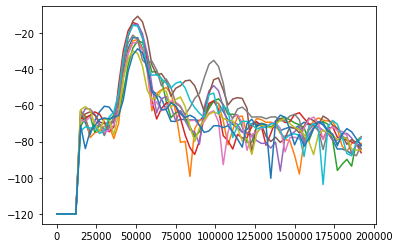

In [21]:
# Plot dBFS over frequency (Hz). Only for test and to visualise detected peaks.
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       kaiser_window, kaiser_dbfs_max)
    # Cut off low frequencies.
    dbfs_spectrum[(freq_bins_hz < cutoff_freq_hz)] = -120.0
    plt.plot(freq_bins_hz, dbfs_spectrum)
plt.show()

In [22]:
# List peak and dBFS.
for index in peaks:
    dbfs_spectrum = calc_dbfs_spectrum(signal[index-half_window:index+half_window], 
                                       kaiser_window, kaiser_dbfs_max)
    # Cut off low frequencies.
    dbfs_spectrum[(freq_bins_hz < cutoff_freq_hz)] = -100.0
    # Find max.
    bin_peak_index = dbfs_spectrum.argmax()
    peak_frequency_hz = bin_peak_index * sampling_freq / window_size
    time = index / sampling_freq
    db_peak = np.max(dbfs_spectrum)
    print('Time: ' + str(time) + '  Freq.: ' + str(peak_frequency_hz) + '  dBFS: ' + str(db_peak))

Time: 0.07  Freq.: 51000.0  dBFS: -22.593795788285625
Time: 0.155  Freq.: 51000.0  dBFS: -23.635383204768754
Time: 0.239  Freq.: 51000.0  dBFS: -24.299763873107945
Time: 0.329  Freq.: 48000.0  dBFS: -14.183709563505023
Time: 0.41  Freq.: 51000.0  dBFS: -15.18812459704461
Time: 0.492  Freq.: 51000.0  dBFS: -10.753207094810818
Time: 0.588  Freq.: 51000.0  dBFS: -25.053098021505345
Time: 0.672  Freq.: 48000.0  dBFS: -21.199569942480036
Time: 0.759  Freq.: 48000.0  dBFS: -29.985802149780355
Time: 0.85  Freq.: 48000.0  dBFS: -15.710762169240517
Time: 0.952  Freq.: 51000.0  dBFS: -28.74281146866207


### Extract points before and after peaks.

In [23]:
time_s = []
freq_khz = []
amp_dbfs = []

for peak_position in peaks:
    size = 256 # From -16 ms to + 16 ms * 8 per ms.
    jump = int(sampling_freq/1000/8) # Jump 0.125 ms.
    start_index = int(peak_position - (size * jump / 2))                
    matrix = calc_dbfs_matrix(signal[start_index:], matrix_size=size, jump=jump)
    # Get max dBFS value.
    row, col = np.unravel_index(matrix.argmax(), matrix.shape)
    calc_peak_freq_hz, calc_peak_dbfs = interpolate_spectral_peak(matrix[row])
    #
    if (calc_peak_freq_hz > cutoff_freq_hz) and (calc_peak_dbfs > -50):
        if calc_peak_dbfs > noise_level_dbfs + 3.0:
            plot_threshold = np.maximum(calc_peak_dbfs - 20.0, -50.0)
            for spectrum_index, spectrum in enumerate(matrix):
                freq_hz, dbfs = interpolate_spectral_peak(spectrum)

                if dbfs > plot_threshold:
                    out_row = []
                    # 'time_s'
                    signal_index = (start_index + (spectrum_index * jump))
                    time_s.append(np.round(signal_index / sampling_freq, 5))
                   # 'peak_khz'
                    freq_khz.append(np.round(freq_hz/1000, 3))
                    # 'dbfs'
                    amp_dbfs.append(np.round(dbfs, 2))

### Plot result

In [24]:
# Prepare data frame.
peak_df = pd.DataFrame()
peak_df['Time (s)'] = time_s
peak_df['Frequency (kHz)'] = freq_khz
peak_df['Amplitude (dBFS)'] = amp_dbfs
peak_df['Compressed time (s)'] = [x*0.125/1000 for x in range(0, len(peak_df.index))]
peak_df.head()

,Time (s),Frequency (kHz),Amplitude (dBFS),Compressed time (s)
0,0.06775,61.271,-36.53,0.000000
1,0.06788,60.640,-30.24,0.000125
2,0.06800,55.409,-37.15,0.000250
3,0.06813,55.918,-30.58,0.000375
4,0.06825,55.488,-27.56,0.000500


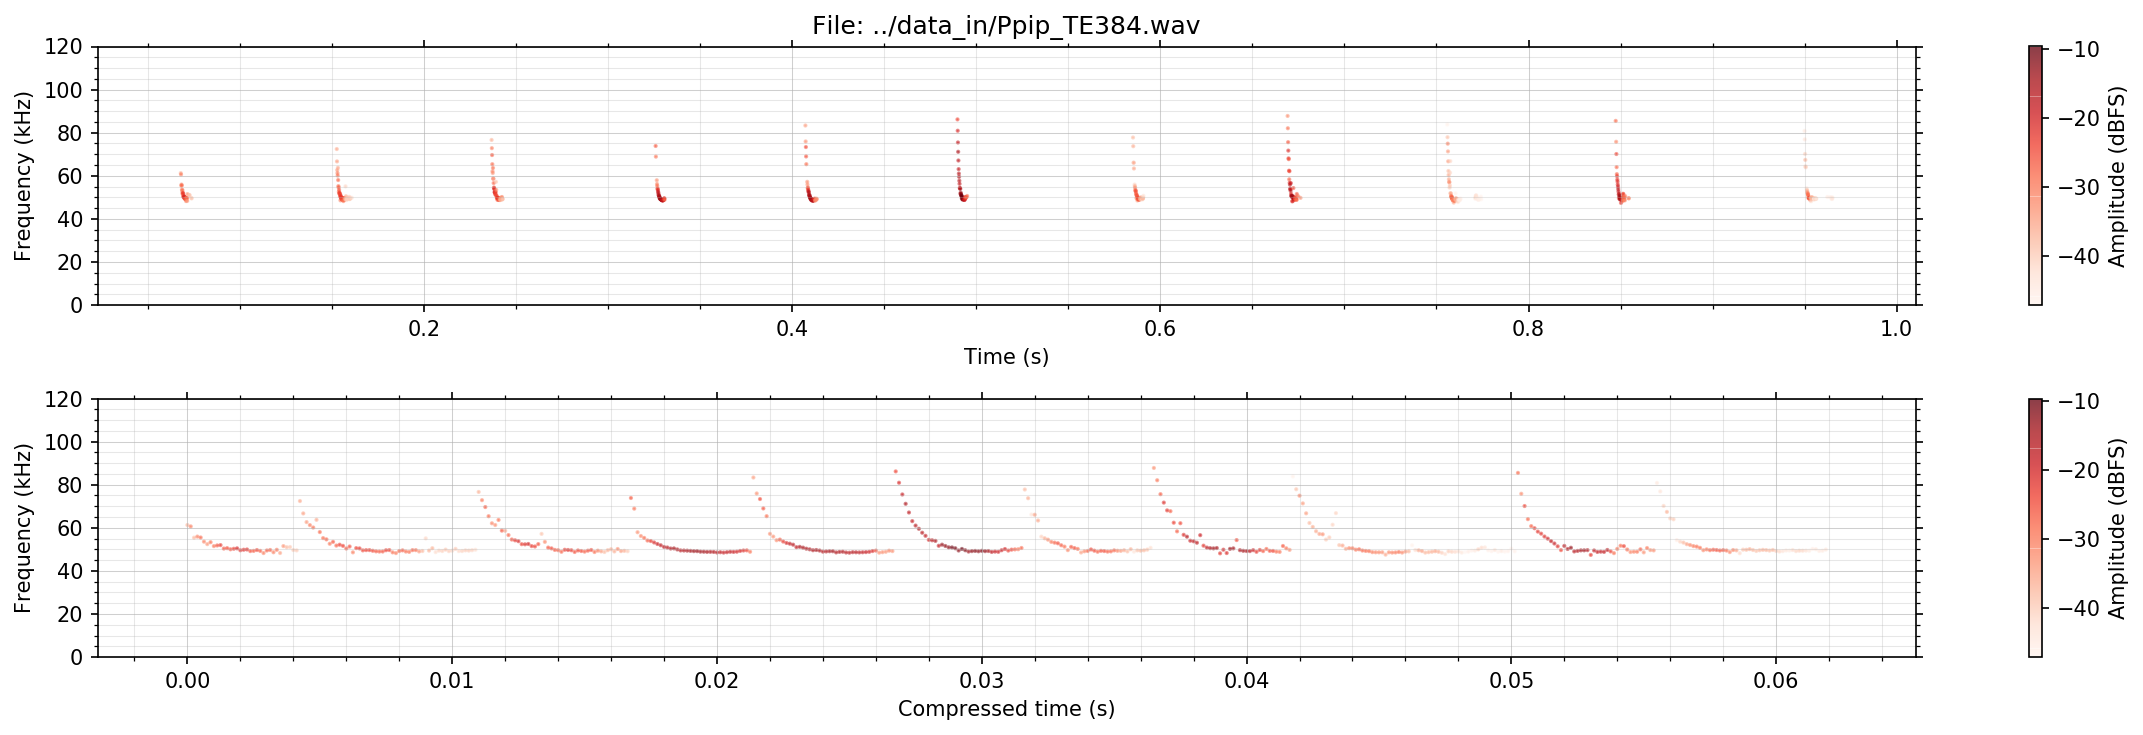

In [25]:
# Plot two diagrams, normal and compressed time.
fig, (ax1, ax2) = plt.subplots(2,1,
                       figsize=(16, 5), 
                       dpi=150, 
                       #facecolor='w', 
                       #edgecolor='k',
                              )
# ax1.
peak_df.plot(kind='scatter',
             x='Time (s)',
             y='Frequency (kHz)',
             s=1,
             c='Amplitude (dBFS)',
             cmap=plt.get_cmap('Reds'),  #'YlOrRd'
             alpha=0.5,
             ax=ax1)
ax1.set_title('File: ' + sound_file)
ax1.set_ylim((0,120))
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
ax1.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
ax1.tick_params(which='both', top='off', left='off', right='off', bottom='off') 
# ax2.
peak_df.plot(kind='scatter',
             x='Compressed time (s)',
             y='Frequency (kHz)',
             s=1,
             c='Amplitude (dBFS)',
             cmap=plt.get_cmap('Reds'),  #'YlOrRd'
             alpha=0.5,
             ax=ax2)
ax2.set_ylim((0,120))
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
ax2.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
ax2.tick_params(which='both', top='off', left='off', right='off', bottom='off') 

plt.tight_layout()
fig.savefig('zc_in_frequency_domain_test.png')
#fig.savefig('zc_in_frequency_domain_test_1.png')
#fig.savefig('zc_in_frequency_domain_test_2.png')
plt.show()